In [8]:
import rdkit

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
import matplotlib.ticker as mtick
from scipy import stats
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors as _rdMolDescriptors

MolWt = lambda *x,**y:_rdMolDescriptors._CalcMolWt(*x,**y)

sns.set_theme(style="whitegrid")

# Read Data

In [2]:
dude_df = pd.read_csv('dude.csv')
bindingdb_df = pd.read_csv('bindingdb.csv')
bindingdb_df.rename({'Ligand SMILES': 'SMILES'},
                    axis=1,
                    inplace=True)
df = pd.concat([dude_df[['SMILES', 'active']],
                bindingdb_df[['SMILES', 'active']]],
                ignore_index=True).drop_duplicates()

In [6]:
df.shape

(27497, 2)

In [7]:
bindingdb_df.shape

(4161, 4)

In [3]:
def get_molwt(row):
    return MolWt(Chem.MolFromSmiles(row))

def canonize_smiles(row):
    return Chem.MolToSmiles(Chem.MolFromSmiles(row))

df['SMILES'] = df['SMILES'].apply(canonize_smiles)
bindingdb_df['SMILES'] = bindingdb_df['SMILES'].apply(canonize_smiles)
df['MolWt'] = df['SMILES'].apply(get_molwt)
bindingdb_df['MolWt'] = bindingdb_df['SMILES'].apply(get_molwt)
df = df.drop_duplicates(subset=['SMILES'])
bindingdb_df = bindingdb_df.drop_duplicates(subset=['SMILES'])

print(df.shape)
df.head()

(27454, 3)


,SMILES,active,MolWt
0,CS(=O)(=O)N1CCN(C(=O)C(Cc2cccc(C(N)=[NH2+])c2)...,1,544.679
2,NC(=[NH2+])N1CCC(CC(=O)C2Cc3cccc4c3N2C(=O)C(NS...,1,552.677
3,CC(C)C(Cl)C(NC(=O)C(O)Cc1ccccc1)C(=O)N1C(C(=O)...,1,597.180
4,Cc1cc(OCCCON=C(N)N)cc(C(=O)N(Cc2ccncc2)CC2CC2)c1,1,411.506
5,CCSCCN(Cc1ccoc1)C(=O)c1cc(C)cc(OCCCON=C(N)N)c1,1,434.562


# Remove Outliers

In [4]:
def remove_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    print('Q1', Q1, 'Q3', Q3, 'IQR', IQR,
          'Q1 - 1.5 * IQR', (Q1 - 1.5 * IQR),
          'Q3 + 1.5 * IQR', Q3 + 1.5 * IQR)
    
    return df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

cols = ['MolWt']
clf_df = remove_outliers(df, cols)
reg_df = remove_outliers(bindingdb_df, cols)
reg_df = remove_outliers(reg_df, [])

Q1 MolWt    398.394
Name: 0.25, dtype: float64 Q3 MolWt    486.593
Name: 0.75, dtype: float64 IQR MolWt    88.199
dtype: float64 Q1 - 1.5 * IQR MolWt    266.0955
dtype: float64 Q3 + 1.5 * IQR MolWt    618.8915
dtype: float64
Q1 MolWt    423.424
Name: 0.25, dtype: float64 Q3 MolWt    547.681
Name: 0.75, dtype: float64 IQR MolWt    124.257
dtype: float64 Q1 - 1.5 * IQR MolWt    237.0385
dtype: float64 Q3 + 1.5 * IQR MolWt    734.0665
dtype: float64


In [6]:
reg_df.head()

,SMILES,Ki (nM),log10Ki,active,MolWt
0,N=C(N)c1cccc(CN2CCN(S(=O)(=O)c3cc4ccc(Cl)cc4s3...,4000.0,3.602060,1,462.984
1,N=C(N)c1ccc(CN2CCN(S(=O)(=O)c3cc4ccc(Cl)cc4s3)...,4000.0,3.602060,1,462.984
2,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cn...,4000.0,3.602060,1,505.021
3,O=C1CN(S(=O)(=O)C=Cc2ccc(Cl)s2)CCN1Cc1cc2cnccc...,4000.0,3.602060,1,436.946
4,COC(=O)[C@H](Cc1cccc(C(=N)N)c1)[C@@H](C)NC(=O)...,3000.0,3.477121,1,458.562


In [7]:
reg_df.shape

(3951, 5)

In [8]:
reg_df = remove_outliers(reg_df, ['log10Ki'])
reg_df.shape

Q1 log10Ki    1.278754
Name: 0.25, dtype: float64 Q3 log10Ki    3.69897
Name: 0.75, dtype: float64 IQR log10Ki    2.420216
dtype: float64 Q1 - 1.5 * IQR log10Ki   -2.351571
dtype: float64 Q3 + 1.5 * IQR log10Ki    7.329295
dtype: float64


(3940, 5)

<AxesSubplot:>

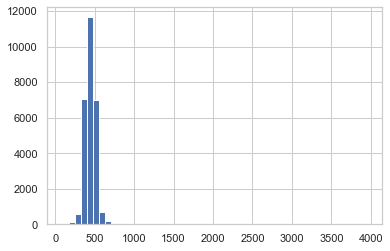

In [5]:
df.MolWt.hist(bins=50)

<AxesSubplot:>

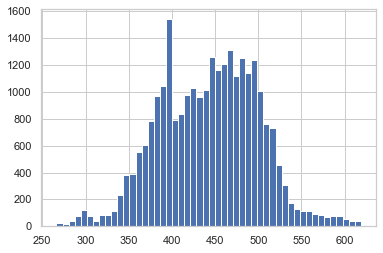

In [7]:
clf_df.MolWt.hist(bins=50)

<AxesSubplot:>

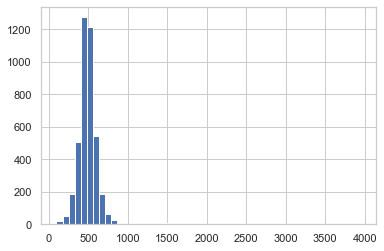

In [8]:
bindingdb_df.MolWt.hist(bins=50)

<AxesSubplot:>

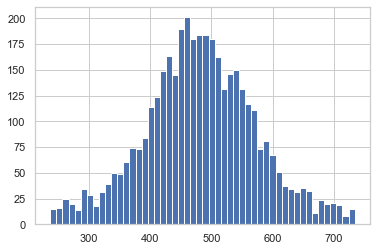

In [9]:
reg_df.MolWt.hist(bins=50)

# Plot Distributions

In [52]:
print(clf_df.shape, reg_df.shape)

(26808, 3) (3951, 5)


In [30]:
clf_df['active'].value_counts()

0    23243
1     3565
Name: active, dtype: int64

In [31]:
reg_df['active'].value_counts()

1    3225
0     726
Name: active, dtype: int64

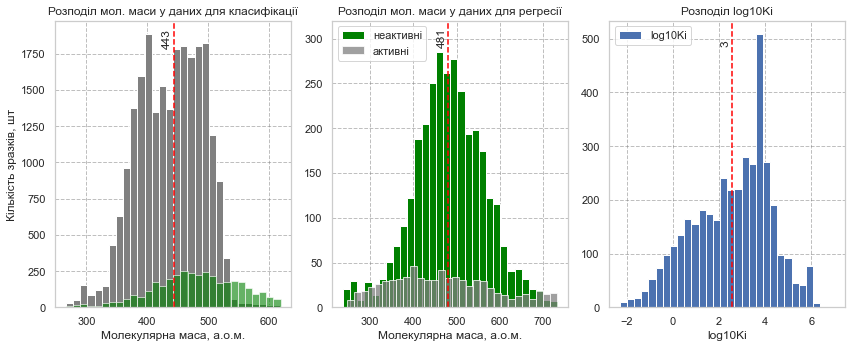

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,
#                              sharey=True,
#                              sharex=True,
                             figsize=(12, 5))

ax1.grid(color = 'gray', linestyle = '--', linewidth = 1, alpha=.5)
ax2.grid(color = 'gray', linestyle = '--', linewidth = 1, alpha=.5)
ax3.grid(color = 'gray', linestyle = '--', linewidth = 1, alpha=.5)

clf_df[clf_df['active']==0]['MolWt'].hist(bins=30, color='grey', ax=ax1)
clf_df[clf_df['active']==1]['MolWt'].hist(bins=30, color='green', ax=ax1, alpha=0.6)
reg_df[reg_df['active']==1]['MolWt'].hist(bins=30, color='green', ax=ax2)
reg_df[reg_df['active']==0]['MolWt'].hist(bins=30, color='grey', ax=ax2, alpha=0.75)
reg_df['log10Ki'].hist(bins=30, ax=ax3)
clf_mean = clf_df['MolWt'].mean()
reg_mean = reg_df['MolWt'].mean()
ki_mean = reg_df['log10Ki'].mean()

ax1.set_title('Розподіл мол. маси у даних для класифікації')
ax1.set_xlabel('Молекулярна маса, а.о.м.')
ax1.set_ylabel('Кількість зразків, шт')
# ax1.legend(['неактивні', 'активні'], loc='upper left')
ax1.axvline(clf_mean, color='red', linestyle='--')
ax2.set_ylim([0, 1850])
ax1.text(clf_mean-11,
         1800,
#          weight='bold',
         f'{clf_mean:.0f}',
         rotation=90,
         horizontalalignment='center',
#          va='top'
        )

ax2.set_title('Розподіл мол. маси у даних для регресії')
ax2.set_xlabel('Молекулярна маса, а.о.м.')
# ax2.set_ylabel('Кількість зразків, шт')
ax2.legend(['неактивні', 'активні'], loc='upper left')
ax2.axvline(reg_mean, color='red', linestyle='--')
ax2.set_ylim([0, 320])
ax2.text(reg_mean-15,
         292,
#          weight='bold',
         f'{reg_mean:.0f}',
         rotation=90,
         horizontalalignment='center',
#          va='top'
        )

ax3.set_title('Розподіл log10Ki')
ax3.set_xlabel('log10Ki')
ax3.legend(['log10Ki'], loc='upper left')
# ax3.set_ylabel('Кількість зразків, шт')
# ax3.legend(['неактивні', 'активні'])
ax3.axvline(ki_mean, color='red', linestyle='--')
ax3.text(ki_mean-0.3,
         490, 
#          weight='bold',
         f'{ki_mean:.0f}',
         rotation=90,
         horizontalalignment='center',
#          verticalalignment='top',
        )

plt.tight_layout()
plt.savefig("data_distributions.png", dpi=300)

In [90]:
clf_df.to_csv('bin_clf_dataset.csv', index=False)
reg_df.to_csv('reg_dataset.csv', index=False)

# Molecular Fragments Analysis

In [82]:
! pip install EFGs

  Created wheel for EFGs: filename=EFGs-0.8.4-py3-none-any.whl size=11345 sha256=d6b6e200287a6ed7e71c528d2d537fb60fc9096f5c400e2f3b148f14e231fe83
  Stored in directory: /Users/ogurb/Library/Caches/pip/wheels/58/54/b6/31d67725608e820013fc0d99419de1b3baa718beb01c16aabf
Successfully built EFGs


In [8]:
import EFGs
EFGs.__version__
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from EFGs import mol2frag
from collections import Counter
# https://github.com/HelloJocelynLu/EFGs/blob/master/Examples/Tutorial.ipynb

## Classification - Active vs Not Active

In [5]:
clf_df = pd.read_csv('bin_clf_dataset.csv')
reg_df = pd.read_csv('reg_dataset.csv')

In [6]:
def count_fragments(series_of_smiles):
    fragm = Counter()

    for smiles in series_of_smiles:
        mol = Chem.MolFromSmiles(smiles)
        a,b = mol2frag(mol)
        fragm.update(a+b)

    print(f'There were {len(fragm)} in total')
    return fragm

def print_dict(d):
    for k, v in d.items():
        print(f'{k:<15}: {v}')

In [9]:
%%time

clf_active_fragm = count_fragments(clf_df[clf_df.active==1]['SMILES'])
clf_inactive_fragm = count_fragments(clf_df[clf_df.active==0]['SMILES'])

There were 230 in total
There were 1840 in total
CPU times: user 4min 58s, sys: 2.24 s, total: 5min
Wall time: 5min 1s


In [20]:
num_most_common = 12

clf_active_fragm2 = dict(clf_active_fragm)
act_fragm_num = sum(clf_active_fragm2.values())
clf_active_fragm2 = {k: v/act_fragm_num for k, v in clf_active_fragm2.items()}

clf_inactive_fragm2 = dict(clf_inactive_fragm)
inact_fragm_num = sum(clf_inactive_fragm2.values())
clf_inactive_fragm2 = {k: v/inact_fragm_num for k, v in clf_inactive_fragm2.items()}

active_fragm_most_common = dict(Counter(clf_active_fragm2).most_common(num_most_common))
inactive_fragm_most_common = {x: clf_inactive_fragm2[x] for x in active_fragm_most_common}

print_dict(active_fragm_most_common)
print()
print_dict(inactive_fragm_most_common)

clf_plot_df = pd.DataFrame(active_fragm_most_common.items(), columns=['fragment', 'active']) 
clf_plot_df['inactive'] = inactive_fragm_most_common.values()

# to percents
clf_plot_df['inactive'] = clf_plot_df['inactive'] * 100
clf_plot_df['active'] = clf_plot_df['active'] * 100

clf_plot_df

C020           : 0.13107553732275037
c1ccccc1       : 0.11564701685543566
C030           : 0.10931508070989031
NC=O           : 0.09303932934986177
C010           : 0.07562650494961205
CC             : 0.06211540176580754
N              : 0.04976366717203246
O              : 0.04167038259163471
F              : 0.030634085436546866
CCC            : 0.02927405689824311
N=CN           : 0.028716668153036654
Cl             : 0.02746811736377419

C020           : 0.10596915058458937
c1ccccc1       : 0.08691717143259614
C030           : 0.10384209043527258
NC=O           : 0.065495140160586
C010           : 0.12899704183687843
CC             : 0.07966967178475842
N              : 0.03301873503310326
O              : 0.08667065783913228
F              : 0.022376391040991688
CCC            : 0.015815607832089025
N=CN           : 0.0010283138470207071
Cl             : 0.01323425834624595


,fragment,active,inactive
0,C020,13.107554,10.596915
1,c1ccccc1,11.564702,8.691717
2,C030,10.931508,10.384209
3,NC=O,9.303933,6.549514
4,C010,7.562650,12.899704
5,CC,6.211540,7.966967
6,N,4.976367,3.301874
7,O,4.167038,8.667066
8,F,3.063409,2.237639
9,CCC,2.927406,1.581561


In [21]:
num_most_common = 12
most_common = None
quantiles, bin_edges = pd.qcut(reg_df['log10Ki'], q=3, labels=['q1', 'q2', 'q3'], retbins=True)
reg_df['quantiles'] = quantiles
print('Bin edges:', bin_edges)
reg_df['quantiles'].value_counts()
reg_fragm_list = []

for q in reg_df.groupby(['quantiles']):
    q_fragm_dict = dict(count_fragments(q[1]['SMILES']))
    act_fragm_num = sum(q_fragm_dict.values())
    q_fragm_dict = {k: v/act_fragm_num for k, v in q_fragm_dict.items()}
    
    if most_common is None:
        most_common = dict(Counter(q_fragm_dict).most_common(num_most_common))
        reg_fragm_list.append(most_common)
    else:
        reg_fragm_list.append({x: q_fragm_dict[x] for x in most_common})
        
reg_plot_df = pd.DataFrame(reg_fragm_list[0].items(), columns=['fragment', 'q1']) 
reg_plot_df['q2'] = reg_fragm_list[1].values()
reg_plot_df['q3'] = reg_fragm_list[2].values()

# to percents
reg_plot_df['q1'] = reg_plot_df['q1'] * 100
reg_plot_df['q2'] = reg_plot_df['q2'] * 100
reg_plot_df['q3'] = reg_plot_df['q3'] * 100

reg_plot_df.head()

Bin edges: [-2.30103     1.92427929  3.59106461  7.        ]
There were 132 in total
There were 151 in total
There were 136 in total


,fragment,q1,q2,q3
0,C020,15.219396,11.510380,10.044569
1,C030,13.326463,8.805790,8.448081
2,NC=O,9.735857,7.897911,9.173152
3,c1ccccc1,9.611108,13.535649,14.714295
4,C010,7.604274,8.323281,7.616577


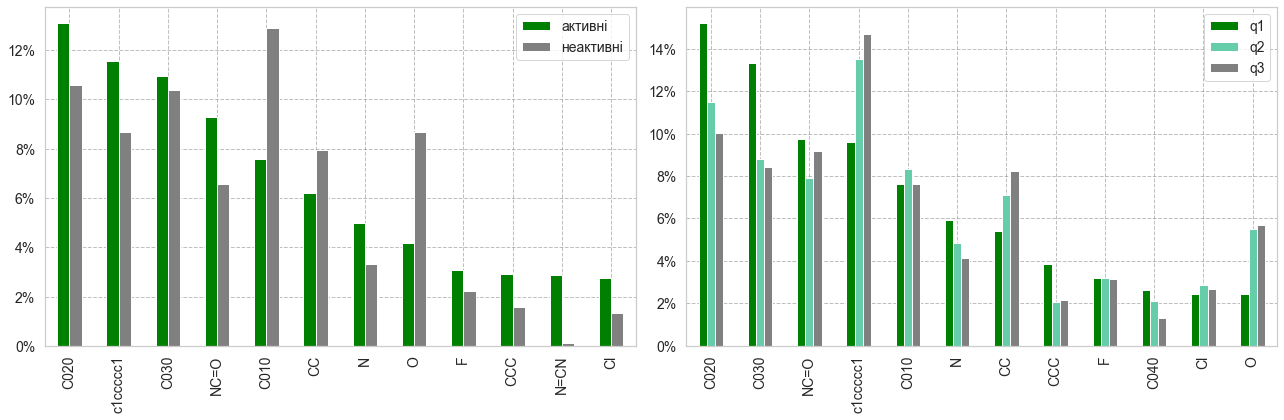

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

clf_plot_df.plot.bar(ax=ax1, color=['green', 'gray'])
reg_plot_df.plot.bar(ax=ax2, color=['green', 'mediumaquamarine', 'grey'])

ax1.grid(color = 'gray', linestyle = '--', linewidth = 1, alpha=.5)
ax2.grid(color = 'gray', linestyle = '--', linewidth = 1, alpha=.5)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

# ax1.set_title('Порівняння частоти зустрічання функціональних груп')
ax1.set_xticks(clf_plot_df.index, labels=clf_plot_df.fragment)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax1.legend(labels=['Активні', 'Неактивні'], fontsize=14)

ax2.set_xticks(reg_plot_df.index, labels=reg_plot_df.fragment)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax2.legend(labels=['q1', 'q2', 'q3'], fontsize=14)

plt.tight_layout()
plt.savefig("func_groups_freq.png", dpi=300)

# FP-FN

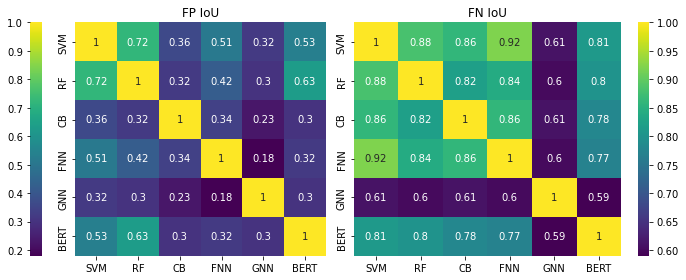

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

cols = ['SVM', 'RF', 'CB', 'FNN', 'GNN', 'BERT']

FPs = [[1,     0.72, 0.36, 0.51, 0.32, 0.53],
        [0.72, 1,    0.32, 0.42, 0.30, 0.63],
        [0.36, 0.32, 1,    0.34, 0.23, 0.30],
        [0.51, 0.42, 0.34, 1,    0.18, 0.32],
        [0.32, 0.30, 0.23, 0.18, 1,    0.30],
        [0.53, 0.63, 0.30, 0.32, 0.30, 1]]

FNs = [[1,     0.88, 0.86, 0.92, 0.61, 0.81],
        [0.88, 1,    0.82, 0.84, 0.60, 0.80],
        [0.86, 0.82, 1,    0.86, 0.61, 0.78],
        [0.92, 0.84, 0.86, 1,    0.60, 0.77],
        [0.61, 0.60, 0.61, 0.60, 1,    0.59],
        [0.81, 0.80, 0.78, 0.77, 0.59, 1]]

f, (ax1, ax2) = plt.subplots(1, 2,
#                              sharey=True,
                             figsize=(10, 4))
sns.heatmap(FPs,
            cmap="viridis",
            annot=True,
            robust=True,
            xticklabels=cols,
            yticklabels=cols,
            cbar_kws={"location": "left"},
            ax=ax1)
sns.heatmap(FNs,
            cmap="viridis",
            annot=True,
            robust=True,
            xticklabels=cols,
            yticklabels=cols,
            ax=ax2)
ax1.set_title('FP IoU')
ax2.set_title('FN IoU')
f.tight_layout()
plt.savefig("seaborn_combine_two_plots_with_shared_x_axis_Python.png", dpi=300)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

cols = ['SVM', 'RF', 'CB', 'FNN', 'GNN', 'BERT']

Accuracy
Precision
Recall
ROC
AUC
Average precision

0.95 0.93 0.94
0.84 0.80 0.87
0.91 0.82 0.77
0.98 0.97 0.97
0.89 0.83 0.87

0.95 0.88 0.87
0.85 0.80 0.69
0.86 0.45 0.55
0.91 0.94 0.90
0.76 0.75 0.70

# GLM Coefficients

In [6]:
import pandas as pd
# 	XGBoost_3_AutoML_2_20220319_231657	1.218019	POS
# 1	XGBoost_2_AutoML_2_20220319_231657	0.996290	POS
# 2	XGBoost_1_AutoML_2_20220319_231657	0.827449	POS
# 3	XGBoost_grid_1_AutoML_2_20220319_231657_model_2	0.399600	POS
# 4	DeepLearning_grid_1_AutoML_2_20220319_231657_model_1	0.361370	POS
# 5	XGBoost_grid_1_AutoML_2_20220319_231657_model_1	0.286282	POS

clf =   [0.23156108557814709,
         0.19992872709190296,
         0.1641342265381297,
         0.08751340510657078,
         0.06657894927684407,
         0.02890562230129885]

# XGBoost_grid_1_AutoML_1_20220319_223540_model_28	0.222424	POS
# 1	XGBoost_grid_1_AutoML_1_20220319_223540_model_19	0.178988	POS
# 2	XGBoost_grid_1_AutoML_1_20220319_223540_model_38	0.148602	POS
# 3	XGBoost_grid_1_AutoML_1_20220319_223540_model_26	0.115002	POS
# 4	DeepLearning_grid_1_AutoML_1_20220319_223540_model_1	0.104676	POS
# 5	XGBoost_grid_1_AutoML_1_20220319_223540_model_32	0.090701	POS

reg =   [0.14280503927810223,
         0.11532934703495447,
         0.09622365721483771,
         0.07380044951809603,
         0.06239864891961441,
         0.057676235283944104]

model = ['GNN', 'CB', 'BERT', 'RF', 'SVM', 'FNN']

df = pd.DataFrame(list(zip(model, clf, reg)),
                  columns =['Model', 'clf', 'reg'])

df['clf'] = (df['clf'] / df['clf'].sum()) * 100
df['reg'] = (df['reg'] / df['reg'].sum()) * 100

df

,Model,clf,reg
0,GNN,29.739858,26.048221
1,CB,25.677251,21.036542
2,BERT,21.080091,17.551587
3,RF,11.239524,13.461502
4,SVM,8.550869,11.381768
5,FNN,3.712408,10.520380


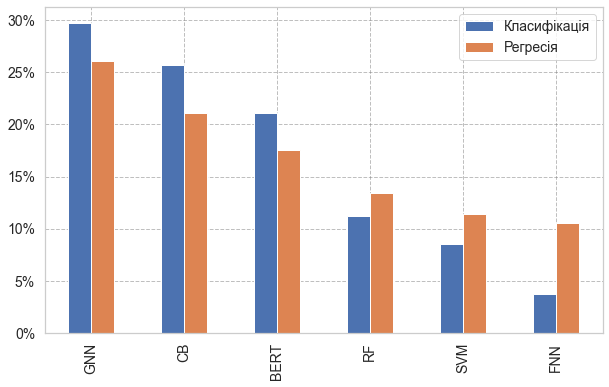

In [11]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

df.plot.bar(ax=ax)

ax.grid(color = 'gray', linestyle = '--', linewidth = 1, alpha=.5)
ax.tick_params(axis='both', which='major', labelsize=14)

# ax1.set_title('Порівняння частоти зустрічання функціональних груп')
ax.set_xticks(df.index, labels=df['Model'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.legend(labels=['Класифікація', 'Регресія'], fontsize=14)


plt.savefig("model_importance.png", dpi=300)